# Cassandra performance analysis

This document contains the results of the performance test that was conducted on a Cassandra cluster designed for storing Financial Exchange Information. The goal was to see if Cassandra is a suitable system for storing high-volumes of data.

The overall approach was as follows: the Financial Exchange Information format was analyzed and the Cassandra data model was designed based on this format for optimal time-series storage on disk. Then sample data was analyzed to generate a stress test that would represent real world data. During the stress test KPIs were monitored to spot potential bottlenecks and get insight in how the system behaves as nodes were added, configurations fine tuned and different loads were used. Based on the results (early) conclusions are drawn to see if Cassandra is fit for storing high-throughput of data.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
import pandas as pd
import matplotlib.pyplot as plt
import gzip
from datetime import datetime
DATA_DIR = 'clean_fix_messages/'

## Cassandra configuration and hardware

### Cluster

The test environment consists of the three Cassandra nodes that form the cluster. It is designed after Amazon's Dynamo and Google's BigTable. Cassandra does not have a master slave configuration, but uses a ring-type architecture (P2P). This architecture prevents the cluster from having a single point of failure (although this turns out not to be completely true, more on this in the conclusion). Data is distributed among the nodes based on the data model.

![cluster](clean_fix_messages/images/cluster-ring.svg)

### Stress testing
Cassandra ships with a `cassandra-stress` tool which is a commandline tool to test your Cassandra cluster and data model. During stress testing CPU, JVM heap, Disk usage, latency and throughput are monitored. To generate a representative load that matches real world data, 10+ million samples were recored and analyzed. Based on this analysis a test script was written (see appendix).

### Data model

In Cassandra the data model is in direct relationship with how data is stored on disk. Therefore designing and testing your data model is important to get the most out of Cassandra. 

Since we are dealing with time-series data the following data model is used:

```cql
CREATE TABLE fix_by_day_test (
  src_id text,
  symbol text,
  day timestamp,
  uts timeuuid,
  fix map,
  PRIMARY KEY ((src_id, symbol, day), uts)
)
```

Data is distributed by a composite key composed of: *Source ID* (i.e. 788 for Euronext), *Symbol* (i.e. AAPL), *day timestamp* (used for bucketing/wide-row), *unique timestamp* (to prevent key collision). And finally a map containing all FIX values.
This data model allows for intra-day querying and data to be stored efficiently based on their source id, symbol and timestamp.

#### Financial Exhange Format (FIX)

The CTF wire protocol is designed for efficient exchange of data and commands between ICE Data Services information products and customers. The protocol enables users of the Client Site Processor (CSP) to receive content from different exchanges using a uniform set of fields

##### Filed Order, Length and Descriptions

| **Field name**           | Fram start | Protocol signature | Length (Bytes)                  | Param                              | Delim   | ... | Param                              | Frame end |
|----------------------|------------|--------------------|-----------------------------|------------------------------------|---------|-----|------------------------------------|----------|
| **Field length (bytes)** | 1          | 1                  | 4                           | Variable                           | 1       | ... | Varaiable                          | 1        |
| **Description**                | `0x4`      | `0x20`             | Unsigned long (Big end-ian) | Token-value pair. Delimited,by "=" | `0x7C`  | ... | Token-value pair. Delimited,by "=" | `0x03`   |

FIX message example (without headers): 

`3=725|4=725|5=MINI-L-OLJA-AVA-227|269=15|12=176.99|25=162237042|885=72|192=2498644|16=1524752557.0594`

#### Theoretical message throughput

The get a accurate calculation of the message size, the average size of the messages must be calculated. This is done by taking the median length of of 10 million messages that were recorded.

In [2]:
# parse message lengths
l = []
with gzip.open(DATA_DIR + 'usa.dat.gz', 'r') as file:
    for line in file:
        fix_len = len(line) - 1 # minus 1 for omitting the \n
        l.append((line, fix_len))

In [3]:
fix = pd.DataFrame(l, columns=['Message', 'Length'])

count    1.025531e+07
mean     9.793072e+01
std      3.379912e+01
min      2.100000e+01
25%      7.500000e+01
50%      9.500000e+01
75%      1.140000e+02
max      1.934000e+03
Name: Length, dtype: float64

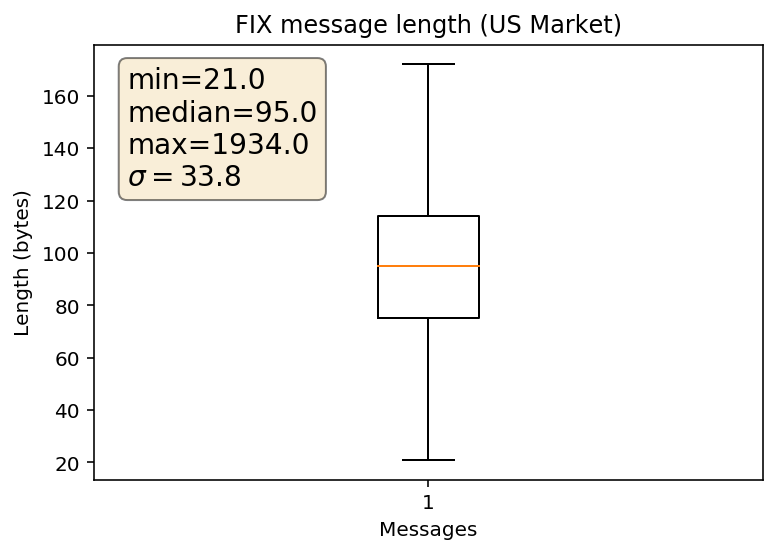

In [5]:
# plot and desribe FIX lengths
length = fix['Length']
fig, ax = plt.subplots(1, 1)
ax.set_ylabel('Length (bytes)');
bp = ax.boxplot(length, 0 , '')

ax.set_title('FIX message length (US Market)')
ax.set_xlabel('Messages')

textstr = 'min=%.1f\nmedian=%.1f\nmax=%.1f\n$\sigma=$%.1f'%(length.min(), length.median(), length.max(), length.std())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props);
length.describe()

Median FIX message size:
$$95 \text{ bytes} = 0,000095 \text{ MB}$$

##### Network message throughput
To calculate the maximal amount of messages that can travel over the NIC, the network bandwidth between nodes must be measured.

###### Measured
|From|To|Bandwidth|
|----|--|---------|
|Node1|Node2|112 MB/sec|

###### Throughput

Network message throughput (1 Gbit/s):
$$\frac{0,000095 MB}{112 \text{ MB/s}} = \lfloor{1.178.947}\rfloor \text{ messages/s}$$

###### Network overhead [Source](https://networkengineering.stackexchange.com/questions/19976/trying-to-find-out-exact-tcp-overhead-cost)

$$ 20b \text{ (TCP)} + 20b \text{ (IP)} + 14b \text{ (Ethernet)} + 4b \text{ (FCS)} + 12b \text{ (Interframe gap)} + 8b \text{ (preamble)} = 78b \text{ overhead}$$

$$78 \text{ bytes} + 95 \text{ bytes} = 173 \text{ bytes}= 0,000173 \text{ MB}$$

$$\frac{0,000173 MB}{112 \text{ MB/s}} = \lfloor{647.398}\rfloor \text{ messages/s}$$


#### Disk/RAID controller message throughput


##### Hardware
|name|ip|note|CPU|Architecture|Memory|NIC|Raid Controller|
|----|--|----|---|------------|------|---|---------------|
|node1|192.168.168.123|seed1|2593.633 MHz Quad-Core AMD Opteron(tm) Processor 2382|x86_64|8 GB|NetXtreme II BCM5708 Gigabit Ethernet|Dell PowerEdge Expandable RAID controller 5|
|node2|192.168.168.125||2593.509 MHz Quad-Core AMD Opteron(tm) Processor 2382|x86_64|8 GB|NetXtreme II BCM5708 Gigabit Ethernet|Dell PowerEdge Expandable RAID controller 5|
|node3|192.168.168.130||2.00GHz Intel(R) Xeon(R) CPU E5405|x86_64|8 GB|NetXtreme II BCM5708 Gigabit Ethernet|LSI Logic / Symbios Logic MegaRAID SAS 1078|

##### Measured
|Node|Disk|Type|Read|Write|Test type|Disk count|
|----|----|----|----|----|----------|----------|
|1|/sda|RAID 1|59.6MB/s-59.6MB/s|39.8MB/s-39.0MB/s|Seq|2|
|1|/sdb|RAID 0|94.3MB/s-94.3MB/s|62.9MB/s-63.2MB/s|Seq|2|
|2|/sda|RAID 1|59.9MB/s-59.9MB/s|39.0MB/s-40.2MB/s|Seq|2|
|2|/sdb|RAID 0|97.9MB/s-97.9MB/s|65.3MB/s-65.5MB/s|Seq|2|

##### Throughput
Disk message write throughput per second (2 disk, RAID 0):
$$\frac{0,000095}{65,5 \text{ MB/s}} = \lfloor{689.473}\rfloor \text{ messages/s}$$

Disk message write throughput per second (2 disk, RAID 1):
$$\frac{0,000095}{40,2 \text{ MB/s}}  = \lfloor{423.157}\rfloor \text{ messages/s}$$

To get 12.5 millions messages per second (network physical limit) we need a bandwidth of:
$$\frac{0,000095}{11.875 \text {MB/s}} = 12.5 \times 10^6 \text{ messages/s}$$

##### 3 node Cassandra cluster throughput
The theoretical throughput is bound by the Disk write throughput. Having three nodes with with two disks in RAID 0, would yield a throughput of $689.473 \times 3 = 2.068.419 \text{ messages/s}$, assuming that Cassandra can keep up and does not introduce major overhead.


## Cassandra stress test results
The following section shows the results of the stress test that is used to measure the upper-bound performance to Cassandra and the data model to store all FIX information.

### 3 Node stress test (RAID 0)
During stress testing the following KPIs were monitored:

- Latency
    - 99th percentile
    - 95th percentile
- Inserted rows per second
- CPU Load
- Memory usage
- Disk data (writes only)

#### Operations per second

##### Latency
![95 percentile](clean_fix_messages/images/95th.png)

![99 percentile](clean_fix_messages/images/99th.png)

##### Rows per second
![Rows per second](clean_fix_messages/images/rows.png)


|Client|Row rate|Latency median|Latency 95th percentile|Latency 99th percentile|Latency 99.9th percentile|Latency max|
|------|--------|--------------|-----------------------|-----------------------|-------------------------|-----------|
|1|189.736 row/s|22,1 ms|77,1 ms|138,4 ms|1676,7 ms|2522,9 ms|
|2|223.587 row/s|17,8 ms|68,3 ms|127,5 ms|1634,7 ms|2516,6 ms|

The results show that there are periodic drop is rows per second and increases in latency. These are probably caused by garbage collection pauses in the JVM. Despite this a total throughput of $413.323 \text{ rows/second}$ is reached.

In [6]:
# Read CSV data
# Node 1
n1_stats = pd.read_csv(DATA_DIR + 'stress-raid0-3n/dstat/n1-10m400t-stress-jmx-raid0.csv')
n1_stats['time'] = n1_stats['time'].map(lambda t: datetime.strptime(t, '%d-%m %H:%M:%S'))

# Node 2
n2_stats = pd.read_csv(DATA_DIR + 'stress-raid0-3n/dstat/n2-10m400t-stress-jmx-raid0.csv')
n2_stats['time'] = n2_stats['time'].map(lambda t: datetime.strptime(t, '%d-%m %H:%M:%S'))

# Node 3
n3_stats = pd.read_csv(DATA_DIR + 'stress-raid0-3n/dstat/n4-10m400t-stress-jmx-raid0.csv')
n3_stats['time'] = n3_stats['time'].map(lambda t: datetime.strptime(t, '%d-%m %H:%M:%S'))

#### CPU Load

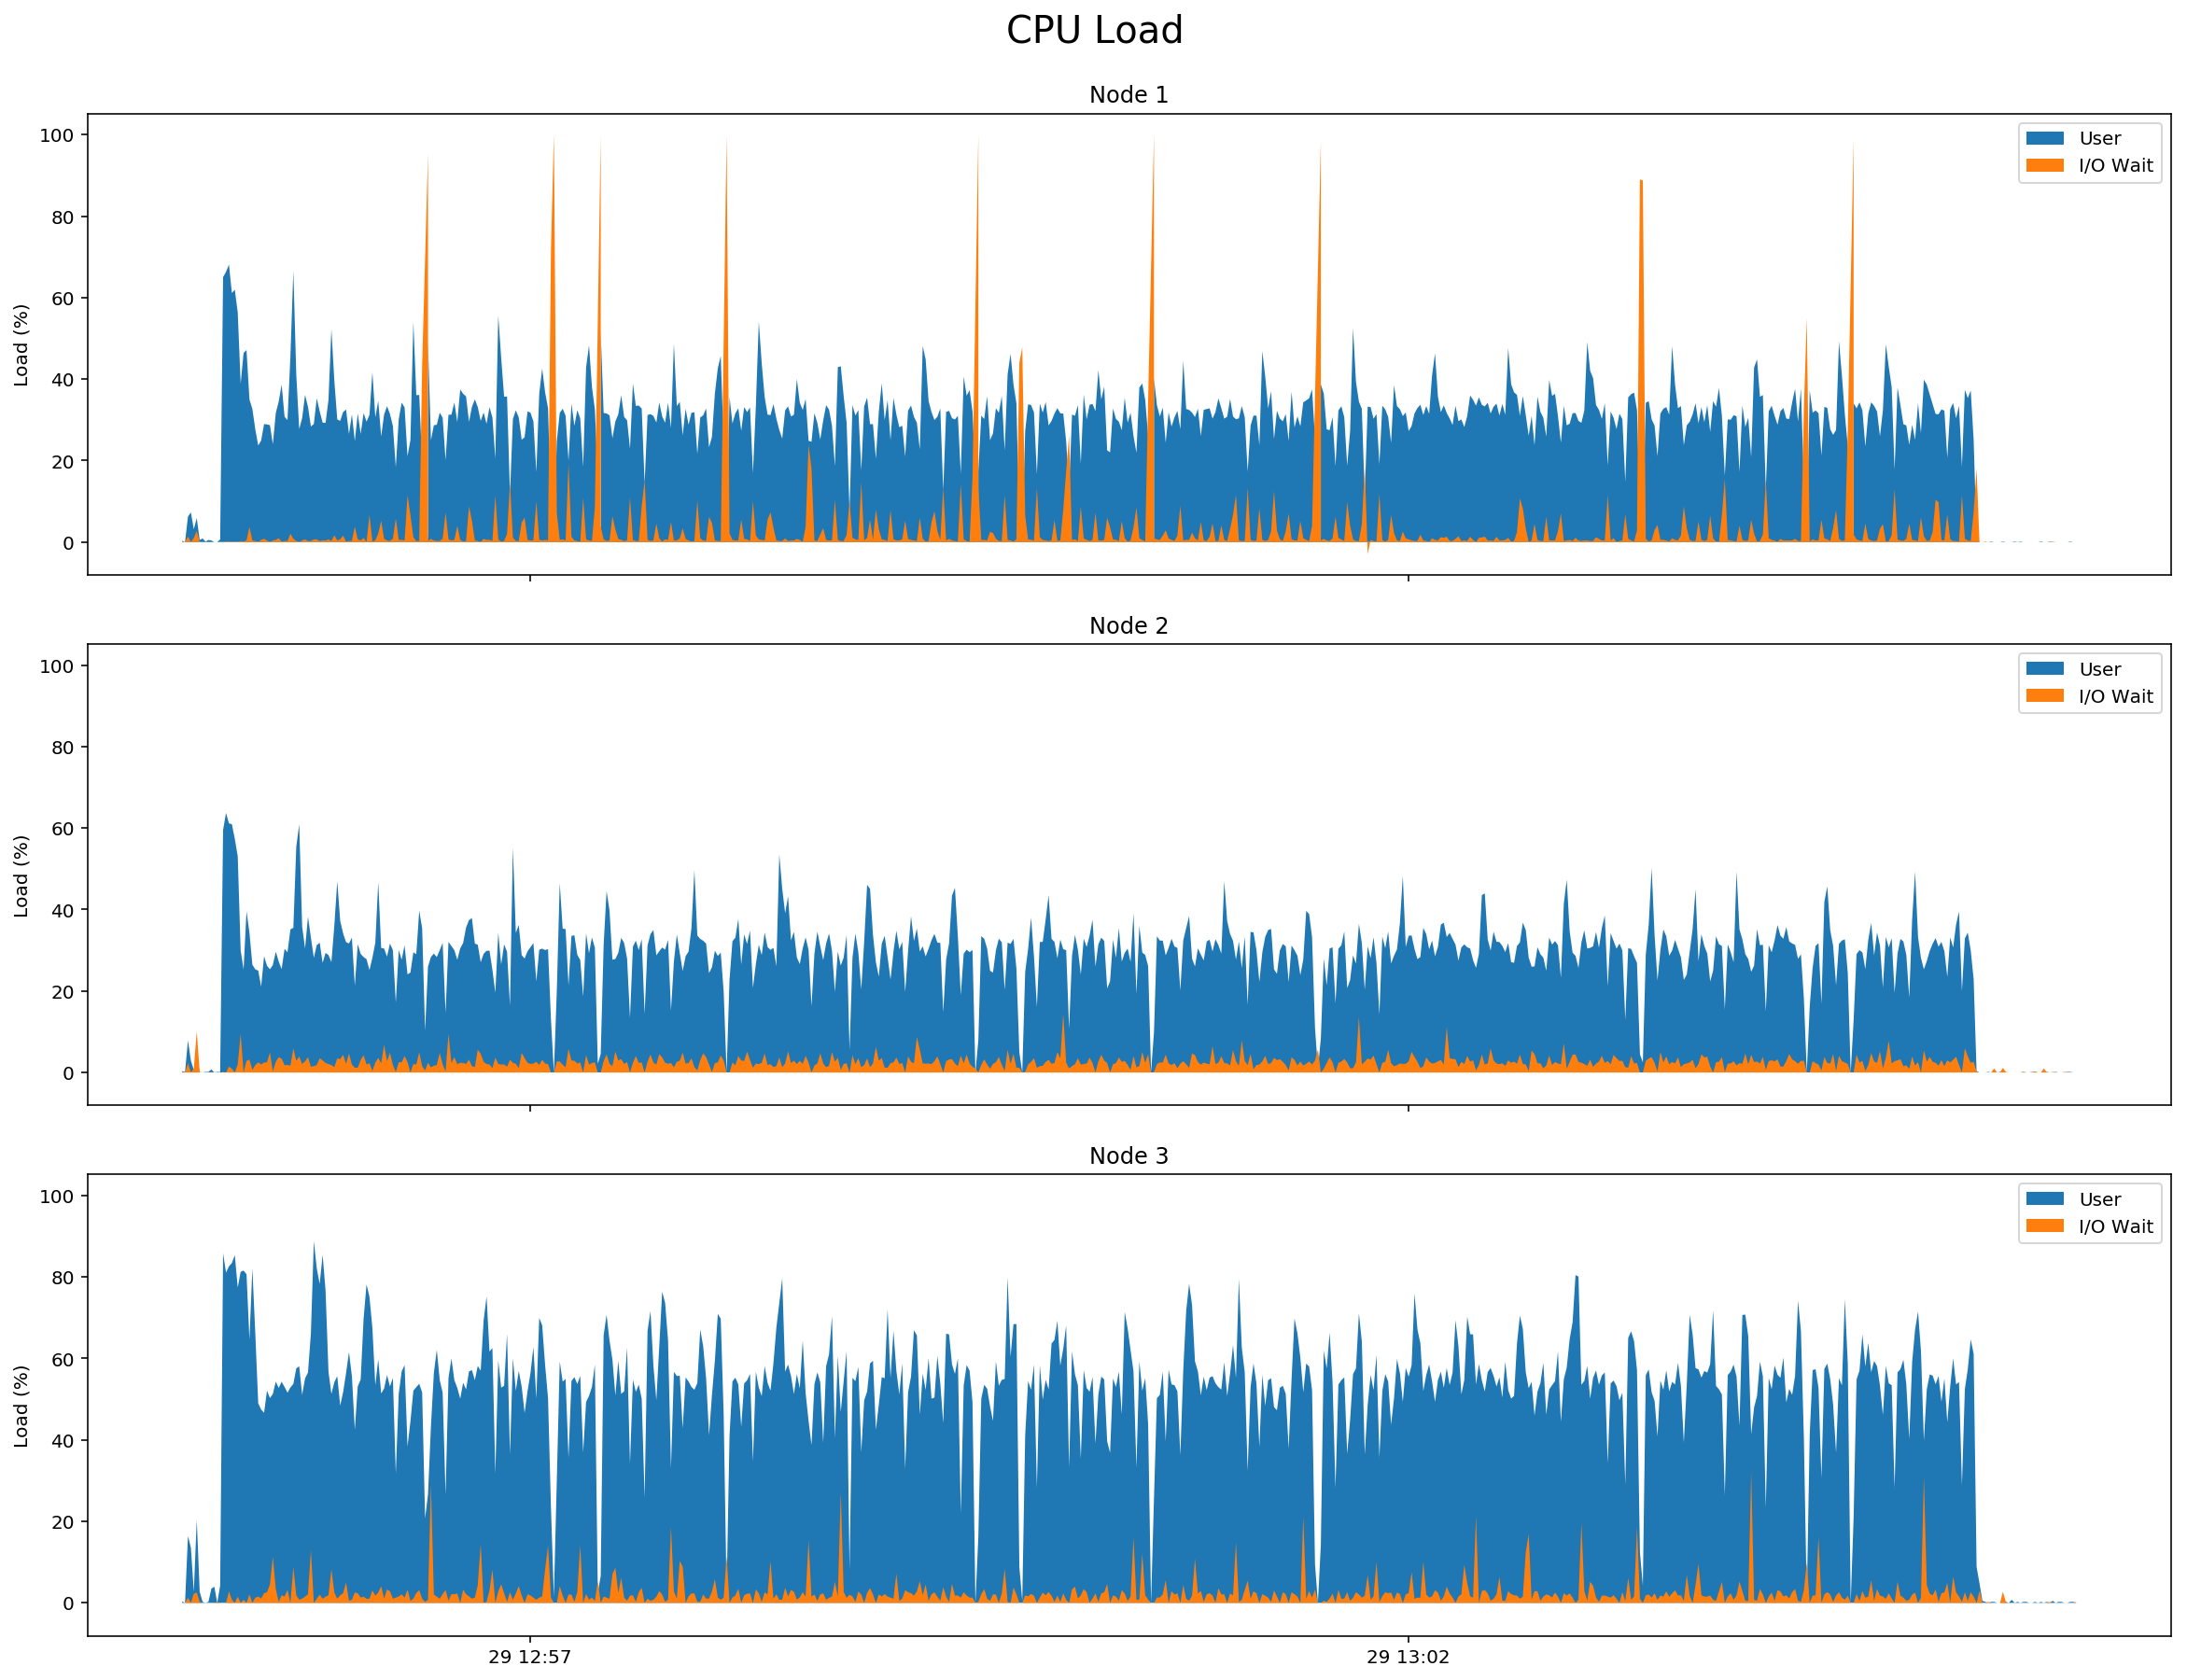

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle('CPU Load', size=20, y=0.93)

fig.subplots_adjust(hspace=0.15)# Bring subplots close to each other.

n1_x, n1_wai, n1_usr = n1_stats['time'].values, n1_stats['wai'].values, n1_stats['usr'].values
ax1.set_title("Node 1")
ax1.set_ylabel('Load (%)')
ax1.fill_between(n1_x, n1_usr, label='User')
ax1.fill_between(n1_x, n1_wai, label='I/O Wait')
legend = ax1.legend(loc='upper right')

n2_x, n2_wai, n2_usr = n2_stats['time'].values, n2_stats['wai'].values, n2_stats['usr'].values
ax2.set_title("Node 2")
ax2.set_ylabel('Load (%)')
ax2.fill_between(n2_x, n2_usr, label='User')
ax2.fill_between(n2_x, n2_wai, label='I/O Wait')
legend = ax2.legend(loc='upper right')

n3_x, n3_wai, n3_usr = n3_stats['time'].values, n3_stats['wai'].values, n3_stats['usr'].values
ax3.set_title("Node 3")
ax3.set_ylabel('Load (%)')
ax3.fill_between(n3_x, n3_usr, label='User')
ax3.fill_between(n3_x, n3_wai, label='I/O Wait')
legend = ax3.legend(loc='upper right');

A few interesting points to notice are:
- Node 1 has I/O wait peaks that translate in latency increase and therefore throughput drops. This Wait propagates to all other nodes of the cluster which can be seen by the User CPU usage drop.
- Data is correctly distributed. Node 1 & 2 have identical hardware specs which is can be seen. Node 3 is higher because it has less powerful cores.

##### I/O Wait
Having a increased latency from time to time is not a issue since the system does not have to be real-time. But it is interesting to see that even though Cassandra claims to have no single-point of failure, because of the ring-type architecture. But the stress test tool was aimed toward Node 1, which makes it responsible to distribute the data to other nodes or persist it locally. But if Node 1 pauses or can't keep up, the whole cluster is affected since traffic is not patched through. 

The cause of the I/O wait is still uncertain. But results indicate that it is *not* the Disk I/O or network bandwidth, but the spikes have a correlation with the heap dips, that is caused by the garbage collection which in turn is a I/O bound operation (memory is freed). Because of time restrictions and not being of a really issue, further investigation of this is not conducted. If time allows for it, GC fine tuning could help reduce the big GC pauses.

#### Memory usage

In [9]:
n1_heap = pd.read_csv(DATA_DIR + 'stress-raid0-3n/jmx/n1.csv')[43:-37]
n2_heap = pd.read_csv(DATA_DIR + 'stress-raid0-3n/jmx/n2.csv')[38:-25]
n3_heap = pd.read_csv(DATA_DIR + 'stress-raid0-3n/jmx/n4.csv')[30:-20]

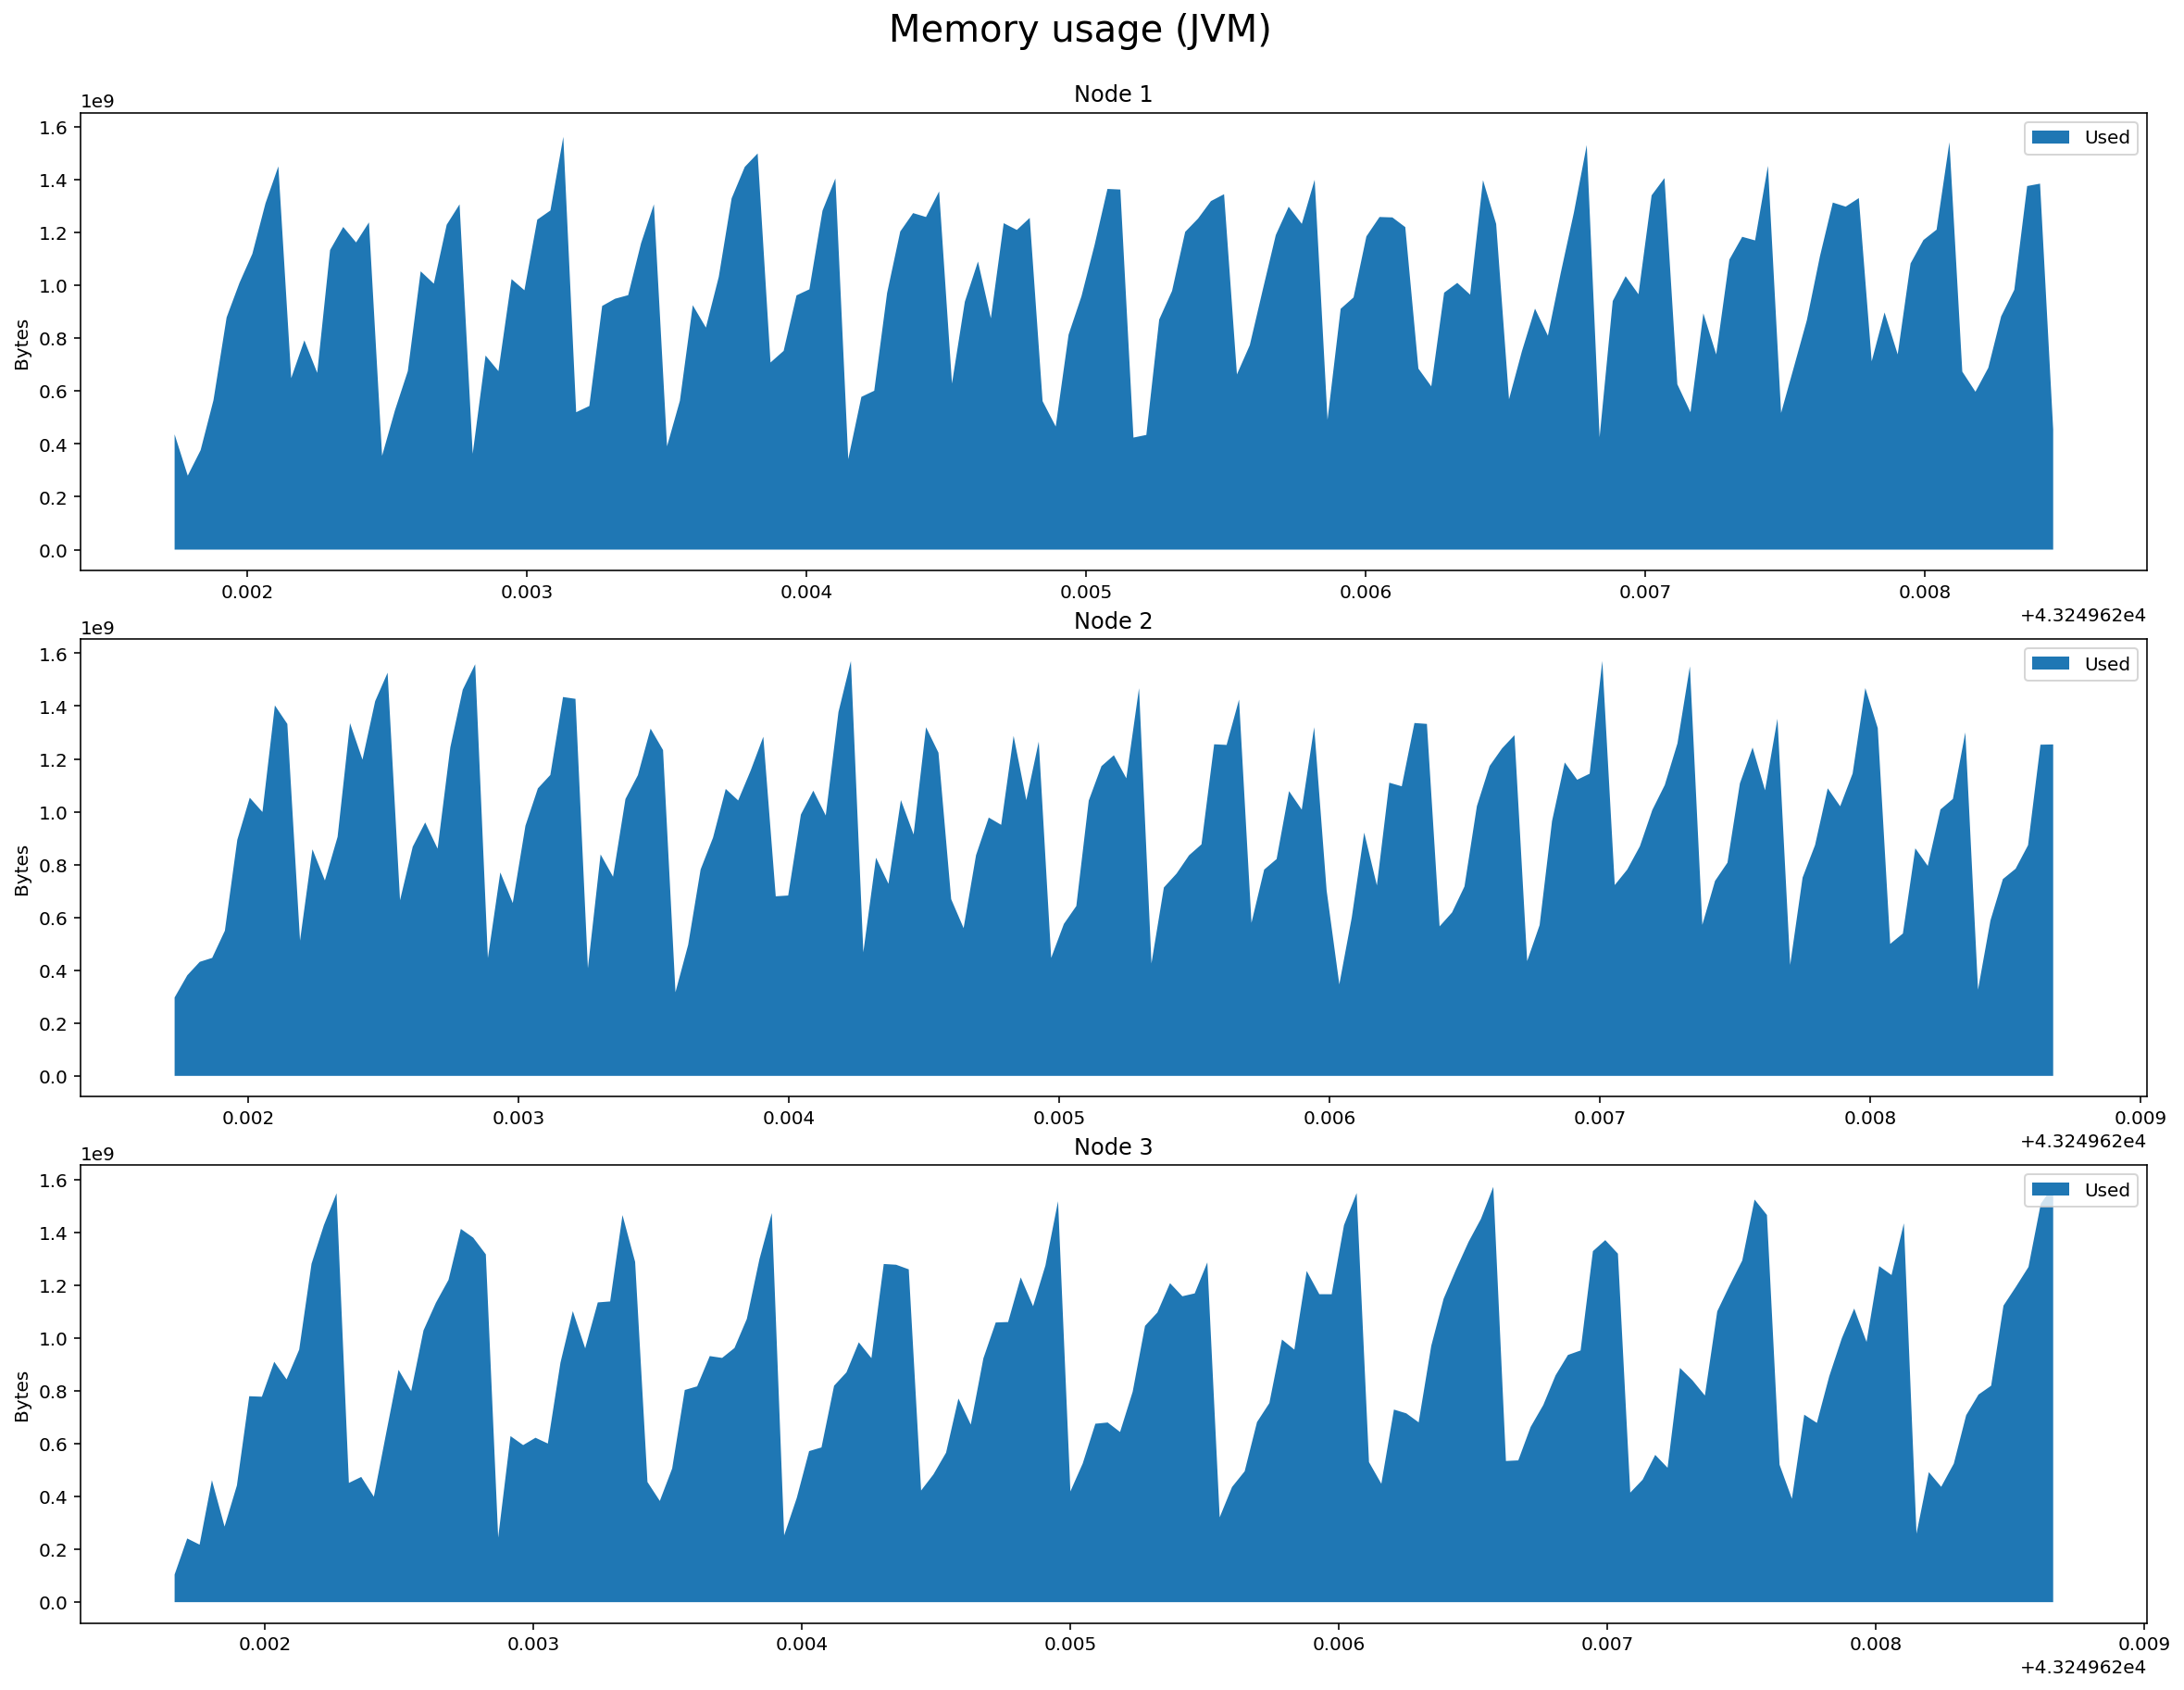

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20, 15),  sharey=True)
fig.suptitle('Memory usage (JVM Heap)', size=20, y=0.93)

fig.subplots_adjust(hspace=0.15)# Bring subplots close to each other.

n1_x, n1_used = n1_heap['Time'].values, n1_heap['Used'].values
ax1.set_title("Node 1")
ax1.set_ylabel('Bytes')
ax1.fill_between(n1_x, n1_used, label='Used');
legend = ax1.legend(loc='upper right')

n2_x, n2_used = n2_heap['Time'].values, n2_heap['Used'].values
ax2.set_title("Node 2")
ax2.set_ylabel('Bytes')
ax2.fill_between(n2_x, n2_used, label='Used')
legend = ax2.legend(loc='upper right')

n3_x, n3_used = n3_heap['Time'].values, n3_heap['Used'].values
ax3.set_title("Node 3")
ax3.set_ylabel('Bytes')
ax3.fill_between(n3_x, n3_used, label='Used')
legend = ax3.legend(loc='upper right');

The exact timestamp of when Garbage collection happened could not be logged. But looking at the JVM heap alone does give it away. There is a distinct sawtooth indicates the freeing of memory. It also shows that memory usage is not maxed out (all servers have 8 GB of memory).

#### Disk Data

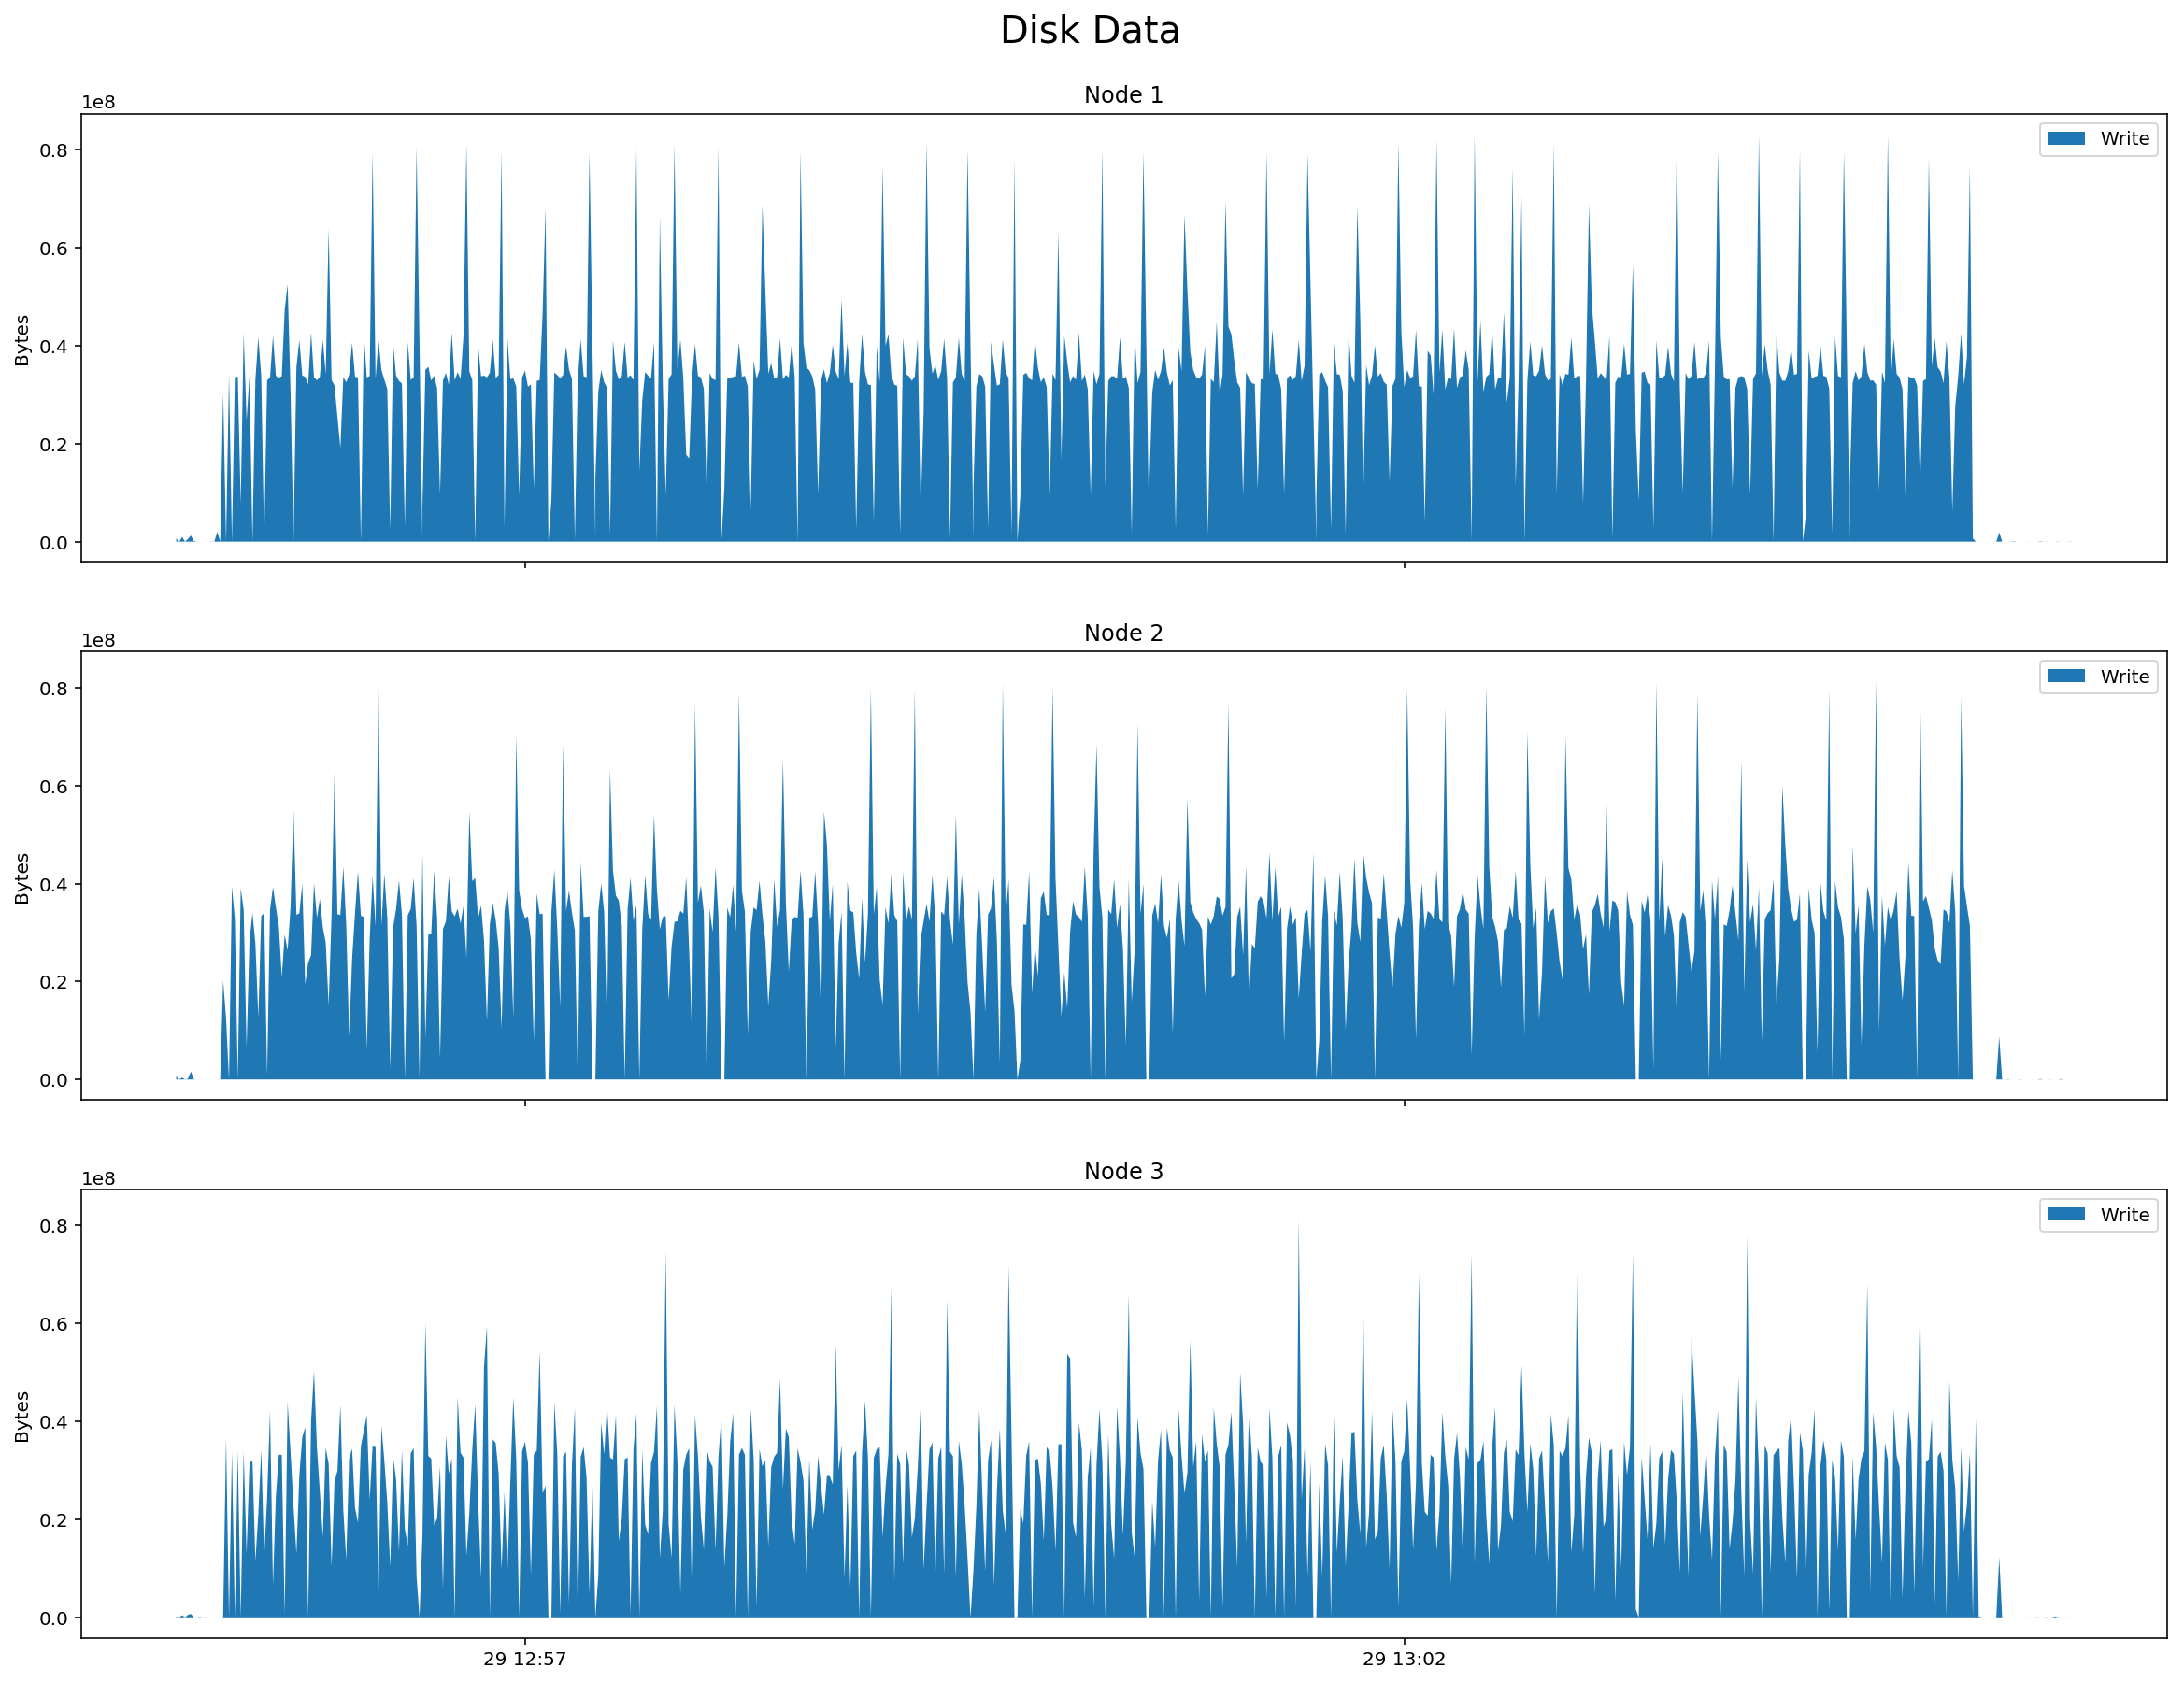

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle('Disk Data', size=20, y=0.93)

n1_t, n1_w = n1_stats['time'], n1_stats['writ']
ax1.fill_between(n1_t.values, n1_w.values, label='Write')
ax1.set_title("Node 1")
ax1.set_ylabel('Bytes')
legend = ax1.legend(loc='upper right')

n2_t, n2_w = n2_stats['time'], n2_stats['writ']
ax2.fill_between(n2_t.values, n2_w.values, label='Write')
ax2.set_title("Node 2")
ax2.set_ylabel('Bytes')
legend = ax2.legend(loc='upper right')

n3_t, n3_w = n3_stats['time'], n3_stats['writ']
ax3.fill_between(n3_t.values, n3_w.values, label='Write')
ax3.set_title("Node 3")
ax3.set_ylabel('Bytes')
legend = ax3.legend(loc='upper right');

Disk usage shows that bandwidth is not fully utilized (63.2 MB/s is the max in RAID-0 2 disk configuration). It is interesting to see the gaps that are caused of earlier mentioned I/O wait in node 1.

## Conclusion/Reflection

At first it looked looked like Cassandra could not handle the load that was generated. After thorough monitoring and testing individual components of the system (Disk I/O, Network I/O, GC, CPU usage etc.). Al these showed that they weren't hitting 100% utilization during stress testing, suggesting that the cluster should be able to handle more.

It turns out that the client was not powerful enough to saturate the cluster. Adding a second client raised the total amount of messages per second to $413.323$ (previously $263,896$). Overall hardware utilization did increase but still not hitting its true potential. 

By adding one or two nodes it should be possible to reach 1 million messages per second. This would be enough for a production deployment this day but scaling out would mean adding more servers. Eventually this would be counter productive considering power consumption, rack space, needed cooling etc.

A solution would be to introduce a system that sits between the network data feed and the long term-storage system, that would act as data ingest/buffer. This ingest would stores in almost raw form and allows other systems to interact with the data on their own time (by backpresure/throttling) to prevent overloading them. And since the markets come and go as they open and close the system can be fine tuned to take advantage of these relative quite periods. 

A promising ingest system is Apache Kafka, just as Cassandra, it uses a log to store its data but without the overhead of a full fledge database. This makes it easy to scale and achieve high-throughput. Cassandra (or any other long-term storage medium) can then, on their own terms, store this data. Preventing overloading the system.

Things to consider:

- A cloud environment
- Did not use newest hardware
- Did not use homogeneous hardware
- Did not test to reach 1 million messages
- Did not fine tune GC/Cassandra any further to see if I/O waits can be resolved


---

## Appendix

### Cassandra-stress file
file: `cs-1-fix-by-day.yaml`

```yaml
#
# Keyspace name and create CQL
#
keyspace: fixstressexample
keyspace_definition: |
  CREATE KEYSPACE fixstressexample WITH replication = {'class': 'SimpleStrategy', 'replication_factor': 1};

#
# Table name and create CQL
#
table: fix_by_day_test
table_definition: |
  CREATE TABLE fix_by_day_test (
      src_id text,
      symbol text,
      day timestamp,
      uts timeuuid,
      fix text,
      PRIMARY KEY ((src_id, symbol, day), uts)
    )
#
# Meta information for generating data
#
columnspec:
  - name: src_id
    size: fixed(3) # We have just one
    population: fixed(788)
  - name: symbol
    size: fixed(7)
    population: uniform(1..288)
  - name: day
    size: fixed(18)
    population: uniform(1..288)
  - name: fix
    size: fixed(285)
  - name: uts
    cluster: fixed(15)
#
# Specs for insert queries
#
insert:
  partitions: fixed(1)      # 1 partition per batch
  batchtype: UNLOGGED       # use unlogged batches
  select: fixed(10)/10      # no chance of skipping a row when generating inserts

#
# Read queries to run against the schema
#
queries:
  pull-for-rollup:
    cql: select * from fix_by_day_test where src_id = ? and symbol = ? and day = ?
    fields: samerow             # pick selection values from same row in partition
```